<a href="https://colab.research.google.com/github/chamodi08jaya/Generative-Adversarial-Networks-GANs-Specialization/blob/main/Generative_Adversarial_Networks_(GAN)_implementation_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [45]:
from os import listdir
import cv2

In [98]:
def load_images(directory, n):
  images= []
  i=0
  for file in listdir(directory):
    filename= directory + file
    image = cv2.imread(filename)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB )
    image = np.asarray(image)
    images.append(image)
    i += 1
    if i >= n:
      break
  return np.array(images)

In [99]:
images = load_images('/content/drive/My Drive/GAN Training/cat_images/cat/', 25)

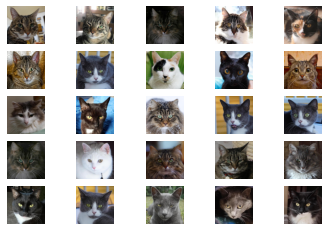

In [100]:
for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(images[i])
plt.show()

In [2]:
# define the discriminator model
def define_D(in_shape=(128,128,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [103]:
model_D =define_D()

In [104]:
model_D.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

In [3]:
# define the generator model
def define_G(latent_dim):
    model = Sequential()
	  # foundation for 16x16 image
    n_nodes = 256 * 16 * 16
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 256)))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsamplde to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7), activation='tanh', padding='same'))
    return model

In [105]:
model_G = define_G(100)
model_G.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 65536)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 128)       524416    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 64, 64, 128)      

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_GAN(model_G, model_D):
	# make weights in the discriminator not trainable
	model_D.trainable = False
	model = Sequential()
	model.add(model_G)
	model.add(model_D)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [106]:
model_gan = define_GAN(model_G, model_D)
model_gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 128, 128, 3)       7686915   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 128961    
Total params: 7,815,876
Trainable params: 7,686,915
Non-trainable params: 128,961
_________________________________________________________________


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
def load_real_images():
    datagen = ImageDataGenerator(rescale=1./255)
    X = datagen.flow_from_directory('/content/drive/My Drive/GAN Training/cat_images',
                                    target_size= (128,128),
                                    batch_size=12500,
                                    class_mode='binary')
    data_list = []
    batch_index = 0
    while batch_index <= X.batch_index:
        data = X.next()
        data_list.append(data[0])
        batch_index += 1
    img_array = np.asarray(data_list)
    return img_array

In [7]:
def generate_real_images(dataset, n_samples):
    i = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[i]
    y = np.ones((n_samples,1))
    return X, y

In [8]:
def generate_latent_points(latent_dim, n_samples):
    X = np.random.randn(latent_dim * n_samples)
    X = X.reshape(n_samples, latent_dim)
    return X

In [9]:
def generate_fake_images(model_G, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim, n_samples)
    X = model_G.predict(X_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [10]:
def summarize_performance(epoch, model_G, model_D, dataset, latent_dim, n_samples=100):
  model_G.save('content/drive/My Drive/GAN Training/cat_images' +str(epoch)+ '.h5')
  X_real, y_real = generate_real_images(dataset, n_samples)
  _, acc_real = model_D.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_images(model_G, latent_dim, n_samples)
  _, acc_fake = model_D.evaluate(x_fake, y_fake, verbose=0)
  print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [11]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch/2)
    # manually enumerate epochs
    for i in range(n_iter):
        X_real, y_real = generate_real_images(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_images(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        print('%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [12]:
def train_GAN(model_G, model_D, model_GAN, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_images(dataset, half_batch)
			X_fake, y_fake = generate_fake_images(model_G, latent_dim, half_batch)
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			d_loss, _ = model_D.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = model_GAN.train_on_batch(X_gan, y_gan)
			print('%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance
		if (i+1) % 10 == 0:
			summarize_performance(i, model_G, model_D, dataset, latent_dim)

In [13]:
latent_dim =100
model_D = define_D()
model_G = define_G(latent_dim)
model_GAN = define_GAN(model_G, model_D)
dataset=load_real_images()


Found 209 images belonging to 1 classes.


In [14]:
train_GAN(model_G, model_D,model_GAN,dataset[0], latent_dim)

1, 1/1, d=0.674, g=0.693
2, 1/1, d=0.646, g=0.691
3, 1/1, d=0.615, g=0.688
4, 1/1, d=0.569, g=0.681
5, 1/1, d=0.529, g=0.661
6, 1/1, d=0.506, g=0.611
7, 1/1, d=0.517, g=0.519
8, 1/1, d=0.631, g=0.428
9, 1/1, d=0.787, g=0.377
10, 1/1, d=0.894, g=0.396
Accuracy real: 100%, fake: 0%
11, 1/1, d=1.086, g=0.461
12, 1/1, d=0.805, g=0.564
13, 1/1, d=0.728, g=0.646
14, 1/1, d=0.698, g=0.724
15, 1/1, d=0.677, g=0.793
16, 1/1, d=0.666, g=0.874
17, 1/1, d=0.655, g=0.952
18, 1/1, d=0.639, g=1.056
19, 1/1, d=0.636, g=1.128
20, 1/1, d=0.646, g=1.107
Accuracy real: 0%, fake: 100%
21, 1/1, d=0.573, g=0.993
22, 1/1, d=0.677, g=0.859
23, 1/1, d=0.684, g=0.763
24, 1/1, d=0.688, g=0.698
25, 1/1, d=0.676, g=0.646
26, 1/1, d=0.665, g=0.604
27, 1/1, d=0.662, g=0.563
28, 1/1, d=0.677, g=0.539
29, 1/1, d=0.702, g=0.544
30, 1/1, d=0.716, g=0.594
Accuracy real: 100%, fake: 0%
31, 1/1, d=0.758, g=0.652
32, 1/1, d=0.677, g=0.703
33, 1/1, d=0.663, g=0.772
34, 1/1, d=0.655, g=0.821
35, 1/1, d=0.651, g=0.825
36, 1/1, 

In [36]:
import os
os.chdir("/content/drive/My Drive/GAN Training/cat_images")

In [107]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

In [108]:
def plot_images(images, n):
	# scales image values in the range of [0,1]
	images = (images-images.min())/(images.max() - images.min())
	for i in range(n):
		# define subplot
		plt.subplot(1, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i, :, :])
	plt.show()

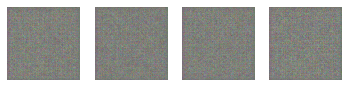

In [116]:
pts = generate_latent_points(100, 30)
# generate images
X = model_G.predict(pts)
# plot the result
plot_images(X, 4)